<a href="https://colab.research.google.com/github/djsabelo/BiosignalsDeepLearningWorkshop/blob/main/SignalProcessingForSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing:

1. Sacar ficheiro - meter em numpy arrays
2. Fazer plot aos dados com dois ou mais sinais
3. Cortar os dados - Precisamos de fazer isto tendo em conta que vamos fazer a segmentação ???
4. Remover a média e normalizar com o maximo absoluto
5. Subamostragem (decimate)
5. Fazer plot aos dados com dois ou mais sinais
6. Remover ruido - smooth
7. Fazer plot aos dados
8. Mostrar e tratar do baseline wander
9. Remover o minimo
10. Quantização
11. Fazer plot aos dados
12. Segmentação - tens que garantir pelo menos 2 ciclos - sliding window (janelas 2^x + 1)
11. Fazer plot de muitas janelas





# Signal Processing for  Synthesis

The application of Deep Learning for biosignals synthesis depends on the quality of signal processing and even on the quality of the raw signal.

In this workshop, we will go through the signal processing steps that are usually applied for biosignals synthesis using Python. Here, we will use **numpy** to ease mathematical operations, **matplotlib** to visualize the results of each step, **scipy** for specific processing operations and **os** to search data files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from scipy.signal import decimate

In [2]:
!git clone https://github.com/djsabelo/BiosignalsDeepLearningWorkshop.git

fatal: destination path 'BiosignalsDeepLearningWorkshop' already exists and is not an empty directory.


## Reading Data

The first step for the application of signal processing is to read the files that contain the data. In this case, we will use ECG files from the Fantasia dataset, that were previously downloaded and, so, can be reached using **os**.

In [3]:
# Find files in folder
folder = './BiosignalsDeepLearningWorkshop/data/'
files = os.listdir(folder)

print(files)

['f1o03m.mat', 'info', 'f1o02m.mat', 'f1o05m.mat', 'f1o01m.mat', 'f1o04m.mat']


Having the list of files we can now read the data contained in them and store them in a list.

However, given that *.mat* files are read as dictionaries, we will simply store the values that correspond to the actual ECG signals. In this case, the key that identifies the signals is *'val'*, thus we index get the values contained in that key.

Moreover, each file contains a respiration signal and an ECG signal, but we will keep only the ECG of each file.

In [4]:
# Iterate over data files and store the data in a list
data = []
for file in files:
  if '.mat' in file: # check if file corresponds to a data file
    folder_file = os.path.join(folder, file) # join the folder path and file name
    signals = loadmat(folder_file)['val'] # Get the signals from file
    single_signal = signals[1] # Get the first signal
    data.append(single_signal) # Load and store the data

Let's check if the data is in the format we expected. In this case, since the sampling frequency is 250 Hz, we will build a time axis using the function **linspace** from **numpy** Python package.

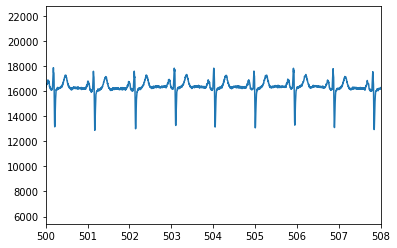

In [5]:
# Get the first signal to plot
signal = data[0]

# Produce the time axis
time = np.arange(0, len(signal)/250, 1/250)

# Make a figure
plt.figure()
# Plot the signal in the figure
plt.plot(time, signal)
# Let's see only part of the signal
plt.xlim(500, 508)
# Show plot
plt.show()

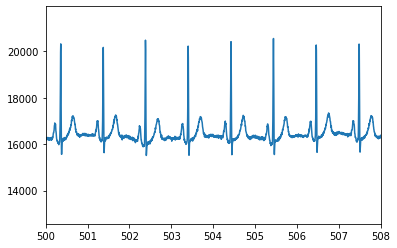

In [6]:
# Let's see the second signal
signal = data[1]
time = np.arange(0, len(signal)/250, 1/250)

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

## Normalise Data

The first step of signal processing is to normalise the signals. 

In this case, we will remove the mean and divide by the maximum of the absolute of the signal so that the resulting values of the signals will be between -0.5 and 0.5.

Since we have various signals, we will interate over the list that contains them and will store them in a list.

In [7]:
# Start the new list
normalised_data = []
# Iterate over all signals
for signal in data:
  mean_value = np.mean(signal) # Calculate the mean of the signal
  abs_signal = np.abs(signal) # Calculate the absolute of the signal
  max_abs_signal = np.max(abs_signal) # Get the maximum value of the absolute signal
  normalised_signal = (signal - mean_value) / max_abs_signal
  normalised_data.append(normalised_signal)

Let's plot the same portions of the same signals. Note that the values of the y-axis changed.

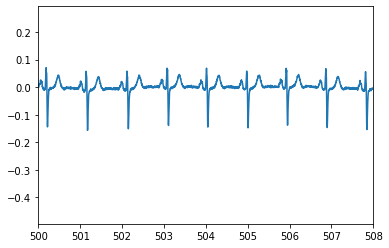

In [8]:
# Let's see the first normalised signal
signal = normalised_data[0]
time = np.arange(0, len(signal)/250, 1/250)

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

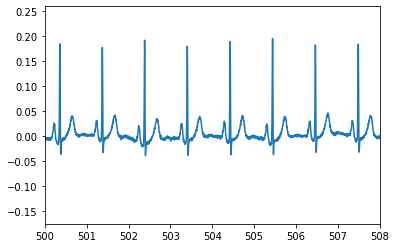

In [9]:
# Let's see the second normalised signal
signal = normalised_data[1]
time = np.arange(0, len(signal)/250, 1/250)

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

## Subsampling

Given that Deep Learning models are "slow" during training, due to the number of iterations and complexity of operations that are required, we will subsample our data, which will save us some time when training our model.

To do this, we will use _decimate_, which is a function from **scipy** which handles this operation maintaing the integrity of the data.

In [10]:
# Build the list to store the subsampled data
subsampled_data = []

# Iterate over the normalised data and subsample
for signal in normalised_data:
  subsampled_signal = decimate(signal, 5) # Subsample by a factor of 5
  subsampled_data.append(subsampled_signal)

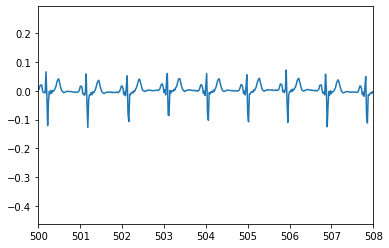

In [11]:
# Let's see the first subsampled signal
signal = subsampled_data[0]
time = np.arange(0, len(signal)/(250/5), 1/(250/5))

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

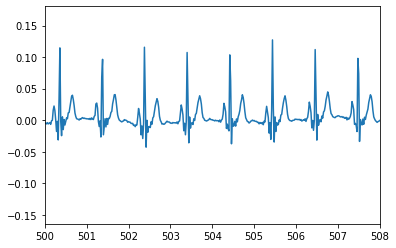

In [12]:
# Let's see the second subsampled signal
signal = subsampled_data[1]
time = np.arange(0, len(signal)/(250/5), 1/(250/5))

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

## Denoise Signals

An important step in most biosignals processing pipelines is to reduce noise in signals. In this sense, we will implement an average filter, which consists on the substitution of each data point by the mean value of its *n* neighbours.

This allows to reduce high frequency noise and to smoothen the signal by choosing a sufficiently large *n*. However, if that value is too large, it will distort the signal and keep only very low frequencies - something we will use to our advantage.

However, there is the problem of the extremes, which does not have neighbours in one of their sides (in the beginning there is not previous values and in the end there is no next values). Thus, our first step will be to build a new array that has the length of the signal plus 2 times the number *n* that will serve as the extremes. The new positions will be filled mirroring of the signal relative to the extremes.

We will use the previously defined signal and *n*=3 for the development.

In [75]:
# Define n
n = 3

# Make an array containing only zeros and with length = length_of_signal + 2*n
extremes_zeros = np.zeros(len(signal) + 2*n)

To make this new array, we will iterate over the subsampled signal and fill the new array according to our description. Thus, the first value of the new array will correspond to the *n*-th value of the subsampled array, the second value will correspond to the *n-1*-th value and so on. When we reach the end of the signal, once we want to mirror the extremes, we fill the next position with the previous value and so on.

In [76]:
for i in range(len(signal)):
    if i < n:
        # mirror the start of signal
        extremes_zeros[i] = signal[n-i]
        # mirror the end of signal
        extremes_zeros[len(signal)+n+i] = signal[len(signal)-i-2]
    # fill the remaining with the signal itself
    extremes_zeros[i+n] = signal[i]

To show the resulting array, we will plot it and show also the subsampled array you previously saw.

200000 200006
True
True
True
[-0.008948564516462896, 0.007252795731377113, 0.02148429727205981, 0.016121755662602412]
[-0.008948564516462896, 0.007252795731377113, 0.02148429727205981, 0.016121755662602412]


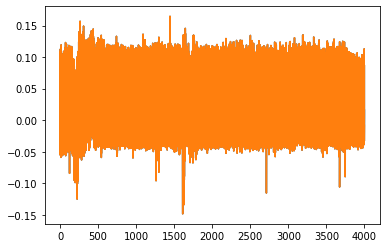

In [77]:
# Let's see the auxiliary signal
mirror_time = np.arange(0, len(extremes_zeros)/(250/5), 1/(250/5))

print(len(signal), len(extremes_zeros))
print(all(extremes_zeros[n:-n] == signal))
print(all(extremes_zeros[:n+1] == signal[:n+1][::-1]))
print(all(extremes_zeros[-n-1:] == signal[-n-1:][::-1]))
print([value for value in extremes_zeros[-n-1:]])
print([value for value in signal[-n-1:][::-1]])

plt.figure()
plt.plot(mirror_time, extremes_zeros)
plt.plot(time + n/(250/5), signal)
plt.show()

Now that we have our auxiliary array with all the values we need, let's build the new array and fill each position with the mean value of its *n* neighbours.

In [78]:
# Build the array
smoothen_signal = np.zeros(len(signal))

# Fill the array
for i in range(n, len(extremes_zeros)-n):
  # Calculate the mean of the neighours - we have to look at the surrounding neighbours, thus we divide the total by 2 look back and further
  mean_neighbours = np.mean(extremes_zeros[i-n//2:i+n//2])
  smoothen_signal[i-n] = mean_neighbours

Let's check the result.

[ 0.00172691  0.00172691  0.00207829 ...  0.01880303  0.01436855
 -0.00084788]


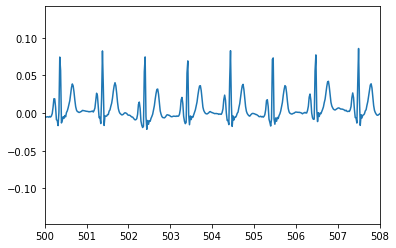

In [79]:
# Let's see the second subsampled signal
print(smoothen_signal)

plt.figure()
plt.plot(time, smoothen_signal)
plt.xlim(500, 508)
plt.show()

To facilitate our job later on, we will save this part of the code in a reusable function that can be run whenever we want. As arguments, we will have the signal and the value *n* and the function will return the smoothened signal.

In [81]:
def smooth(signal, n):
  # Make an array containing only zeros and with length = length_of_signal + 2*n
  extremes_zeros = np.zeros(len(signal) + 2*n)
  for i in range(len(signal)):
    if i < n:
      # mirror the start of signal
      extremes_zeros[i] = signal[n-i]
      # mirror the end of signal
      extremes_zeros[len(signal)+n+i] = signal[len(signal)-i-2]
    # fill the remaining with the signal itself
    extremes_zeros[i+n] = signal[i]
  
  # Build the array
  smoothen_signal = np.zeros(len(signal))

  # Fill the array
  for i in range(n, len(extremes_zeros)-n):
    # Calculate the mean of the neighours - we have to look at the surrounding neighbours, thus we divide the total by 2 look back and further
    mean_neighbours = np.mean(extremes_zeros[i-n//2:i+n//2])
    smoothen_signal[i-n] = mean_neighbours
  
  return smoothen_signal

We can now iterate over the subsampled signals, apply this function and save the resulting smoothened signals in a new list.

In [82]:
# Build the list where we will save the smoothened signals to
smoothened_data = []

# Iterate over the subsampled data and smoothen the signals
for signal in subsampled_data:
  smoothened_signal = smooth(signal, 3) # Subsample by a factor of 5
  smoothened_data.append(smoothened_signal)

## Remove Baseline Wander

The previous step allowed us to remove high-frequency noise from the signal, however, we still need to take care of the low-frequency noise that appears as baseline wander. This kind of noise can be originated by the respiration process which changes the distance between the ECG electrodes when the chest is expanding and contracting.

To reduce this kind of noise we can resource to the smooth function that we previously defined. Namely, if we define a sufficiently large *n* we will keep only the low-frequency components of the signal, which is what we want to remove. Thus, we simply need to subtracte this result from our signal.

Let's see how to do just this.

The first step will be to apply the smoothing function with *n*=400 (a large number) to the previously defined signal.

In [116]:
baseline_wander = smooth(signal, 40)

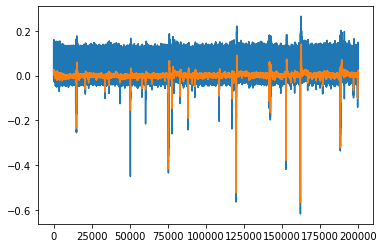

In [117]:
plt.figure()
plt.plot(signal)
plt.plot(baseline_wander)
plt.show()

In [118]:
filtered_signal = signal - baseline_wander

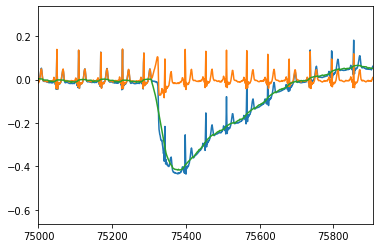

In [119]:
plt.figure()
plt.plot(signal)
plt.plot(filtered_signal)
plt.plot(baseline_wander)
plt.xlim(75000, 75908)
plt.show()

So, we can apply this to all our signals and save them in a new list.

In [122]:
# Build the list where we will save the denoised signals to
denoised_data = []

# Iterate over the subsampled data and smoothen the signals
for signal in smoothened_data:
  denoised_signal = smooth(signal, 40) # Subsample by a factor of 5
  denoised_data.append(denoised_signal)

In [115]:
import scipy.interpolate as itp

def interpolate_signal(time, new_time, signal):
    """
    This function uses the linear interpolates of the input signal with a certain number of samples with "time" 
    timestamp vector, according to the "new_time" vector.
     
    :param time: vector containing the the timestamps for the signal input 
    :param new_time: vector containing the new timestamps for interpolation
    :param signal: vector with the values associated with each timestamp of the "time" vector
    :return: 
        The interpolated version of the input signal for the "new_time" vector timestamps 
    """

    f = itp.interp1d(time, signal, fill_value="extrapolate")
    return f(new_time)


def process_hr(data, quantization_size=1000):
    """
        The function makes a preprocessing for the HR data and also stores the maximum and minimum values of the
        HR across all records in the data dictionary. This preprocessing includes interpolation, minimum subtraction, 
        maximum normalization and quantization. 

        :param data: data dictionary containing all information
        :param quantization_size: number of steps to be used in the quantization process
        :return:
            data: updated version of the dictionary (this may be accessed, since it is a global variable, but for a 
            latter publication of this code, it should be protected) 
            normalized_array: list containing all numpy array processed HR records 
    """
    # For the synchronization of both signals, I chose to interpolate the hr values.
    # Since the hr values are made of a square signal the interpolation will not be far from the original
    interpolated_hr = [interpolate_signal(hr_time, ppg_time, hr)
                       for hr_time, ppg_time, hr in zip(data["hr_times"], data["ppg_times"], data["hr_values"])]

    
    # Check if the interpolation was successfull
    # for i in range(data["size"]):
    #    plt.plot(data["hr_times"][i], normalized_hr[i], "k", alpha=0.7, label="HR")
    #    plt.plot(data["ppg_times"][i], interpolated_hr[i], "b", alpha=0.7, label="HR")
    #    plt.show()

    # In order to maintain the distribution of values across all subjects, I chose to normalize the data according
    # to the minimum and maximum values across the all records

    max = np.max(np.array([np.max(record) for record in interpolated_hr]))
    min = np.min(np.array([np.min(record) for record in interpolated_hr]))
    
    data["hr_max"] = max
    data["hr_min"] = min

    # The minimum is removed and the set is scaled
    normalized_array = [record - min for record in interpolated_hr] # Remove minimum
    normalized_array = [record / max for record in normalized_array] # Normalization step

    # Quantization step
    # this step reduces the dimentionality of the signal, ensuring that the selected model (GRU) learns
    normalized_array = [np.around(record * (quantization_size-1)).astype(int) for record in normalized_array]


    return data, normalized_array

    def process_ppg(records_dictionary, quantization_size=1000):
    times = []
    normalized_array = []
    updated_ppg = []
    for ppg_values, hr_time, ppg_time in \
            zip(records_dictionary["ppg_values"], records_dictionary["hr_times"], records_dictionary["ppg_times"]):
        # Since this data is not synchronized with the hr_data, we will remove the first points which does not have
        # any respective value. Regarding the interpolation of the hr data, this will make the results more reliable.
        first_index = np.where(ppg_time > hr_time[0])[0][0]
        updated_ppg.append(ppg_values[:, first_index:])
        times.append(ppg_time[first_index:])

        normalized_record = ppg_values[:, first_index:]
        normalized_record -= np.expand_dims(np.min(normalized_record, axis=1), -1) \
                             * np.ones((1, np.shape(normalized_record)[-1]))
                             # Remove mean using algebric equation for speed performance
        normalized_record = normalized_record / np.max(abs(normalized_record))  # Normalization step
        #normalized_record = normalized_record / np.std(abs(normalized_record))  # Normalization step
        normalized_array.append(normalized_record)

    return times, normalized_array, updated_ppg

IndentationError: ignored